##  Piza Nava Vladimir - 111-494


## Laboratorio 4

## Link al repositorio: https://github.com/vladi-13/Laboratorios 4 y 5/blob/main/Laboratorio2.ipynb

## Link al dataset: https://www.kaggle.com/datasets/sahilwagh/gold-stock-prices

Este código configura un entorno de trabajo con PyTorch para entrenar redes neuronales (específicamente una RNN y una LSTM), usando distintos dispositivos: una GPU AMD (vía torch-directml) para la RNN y la CPU para la LSTM. Además, importa bibliotecas comunes de ciencia de datos y aprendizaje automático para manejo de datos, entrenamiento y evaluación.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import torch_directml

# Usa GPU DirectML si está disponible, si no, usa CPU
device_rnn = torch_directml.device()
device_lstm = torch.device("cpu")
print("RNN en:", device_rnn)
print("LSTM en:", device_lstm)

RNN en: privateuseone:0
LSTM en: cpu


Carga un CSV llamado "goldstock v1.csv" que contiene datos históricos del oro.

Limpia los datos y escala todas las columnas numéricas entre 0 y 1 usando MinMaxScaler.

Crea secuencias de longitud 20 para predecir el siguiente valor (tipo series temporales).

Divide los datos en entrenamiento (80%) y prueba (20%).

Convierte los datos a tensores y los prepara con DataLoader, listos para entrenar modelos en PyTorch.

In [ ]:
df = pd.read_csv("goldstock v1.csv")

# Asegúrate de que no haya valores nulos
df = df.dropna()

# Usamos todas las columnas excepto 'Date'
features = df.drop(columns=['Date']).values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

SEQ_LEN = 20 # Longitud de la secuencia 20 pasos de tiempo

def create_sequences(data, seq_len):
    X, Y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        Y.append(data[i + seq_len])
    return np.array(X), np.array(Y)

X, Y = create_sequences(features_scaled, SEQ_LEN)

split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, Y_train = X[:split], Y[:split]
X_test, Y_test = X[split:], Y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

dataloader = {
    "train": DataLoader(train_dataset, batch_size=32, shuffle=True),
    "test": DataLoader(test_dataset, batch_size=32)
}

Este código define dos clases:

DeepRNN: una red neuronal recurrente simple.

DeepLSTM: una red con memoria de largo plazo (LSTM).

Ambas toman una secuencia de entrada y devuelven una predicción basada en la última salida de la secuencia. Son ideales para tareas como predicción del siguiente paso en series temporales.

In [ ]:
class DeepRNN(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.rnn = nn.RNN(n_in, n_hidden, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x, _ = self.rnn(x) # RNN devuelve la salida y el estado oculto
        x_last = x[:, -1, :] # Tomamos la última salida de la secuencia
        return self.fc(x_last) # Aplicamos la capa lineal a la última salida

class DeepLSTM(nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super().__init__()
        self.lstm = nn.LSTM(n_in, n_hidden, batch_first=True)
        self.fc = nn.Linear(n_hidden, n_out)

    def forward(self, x):
        x, _ = self.lstm(x)
        x_last = x[:, -1, :]
        return self.fc(x_last)

La función train_model_with_early_stopping entrena un modelo de series temporales (RNN o LSTM) usando:

Función de pérdida: MSELoss (error cuadrático medio).

Optimizador: Adam.

Early stopping: si el modelo no mejora después de cierto número de épocas (patience), se detiene el entrenamiento y se restauran los mejores pesos.


In [55]:
def train_model_with_early_stopping(model, dataloader, device, epochs=100, patience=10):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = None

    for epoch in range(epochs):
        model.train()
        losses = []
        for X_batch, Y_batch in dataloader["train"]:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        epoch_loss = np.mean(losses)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.6f}")

        # Early stopping
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

    # Cargar los mejores pesos del modelo
    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model

La función evaluate_model:

Ejecuta el modelo en el conjunto de prueba.

Recoge todas las predicciones.

Calcula:

MSE entre las predicciones y los valores reales.

"Precisión dentro de ±5%" usando np.isclose.


In [56]:
def evaluate_model(model, dataloader, device, Y_true):
    model.eval()
    preds = []

    with torch.no_grad():
        for X_batch, _ in dataloader["test"]:
            X_batch = X_batch.to(device)
            y_pred = model(X_batch)
            preds.append(y_pred.cpu())

    preds = torch.cat(preds).numpy()

    mse = mean_squared_error(Y_true, preds)
    accuracy = np.mean(np.isclose(Y_true, preds, atol=0.05)) * 100  # margen del 5%

    print(f"🔍 MSE: {mse:.6f}")
    print(f"✅ Accuracy (dentro de ±5%): {accuracy:.2f}%")

    return preds

Este código:

Extrae parámetros de entrada y salida del dataset.

Crea y entrena el modelo RNN en GPU.

Evalúa el modelo y guarda sus pesos.

Repite lo mismo con el modelo LSTM, pero en CPU.



In [57]:
n_in = X_train.shape[2]
n_out = Y_train.shape[1]
n_hidden = 64

# RNN con GPU
rnn = DeepRNN(n_in, n_hidden, n_out)
print("\nEntrenando RNN en GPU...")
rnn_trained = train_model_with_early_stopping(rnn, dataloader, device_rnn, epochs=100)
torch.save(rnn_trained.state_dict(), "rnn_best_model.pth")
rnn_preds = evaluate_model(rnn_trained, dataloader, device_rnn, Y_test.numpy())

# LSTM con CPU
lstm = DeepLSTM(n_in, n_hidden, n_out)
print("\nEntrenando LSTM en CPU...")
lstm_trained = train_model_with_early_stopping(lstm, dataloader, device_lstm, epochs=100)
torch.save(lstm_trained.state_dict(), "lstm_best_model.pth")
lstm_preds = evaluate_model(lstm_trained, dataloader, device_lstm, Y_test.numpy())


Entrenando RNN en GPU...
Epoch 1/100 - Loss: 0.031977
Epoch 2/100 - Loss: 0.003769
Epoch 3/100 - Loss: 0.003414
Epoch 4/100 - Loss: 0.003115
Epoch 5/100 - Loss: 0.002779
Epoch 6/100 - Loss: 0.002738
Epoch 7/100 - Loss: 0.002617
Epoch 8/100 - Loss: 0.002552
Epoch 9/100 - Loss: 0.002539
Epoch 10/100 - Loss: 0.002556
Epoch 11/100 - Loss: 0.002523
Epoch 12/100 - Loss: 0.002535
Epoch 13/100 - Loss: 0.002565
Epoch 14/100 - Loss: 0.002513
Epoch 15/100 - Loss: 0.002567
Epoch 16/100 - Loss: 0.002564
Epoch 17/100 - Loss: 0.002486
Epoch 18/100 - Loss: 0.002502
Epoch 19/100 - Loss: 0.002538
Epoch 20/100 - Loss: 0.002492
Epoch 21/100 - Loss: 0.002578
Epoch 22/100 - Loss: 0.002527
Epoch 23/100 - Loss: 0.002483
Epoch 24/100 - Loss: 0.002492
Epoch 25/100 - Loss: 0.002508
Epoch 26/100 - Loss: 0.002576
Epoch 27/100 - Loss: 0.002458
Epoch 28/100 - Loss: 0.002459
Epoch 29/100 - Loss: 0.002484
Epoch 30/100 - Loss: 0.002515
Epoch 31/100 - Loss: 0.002441
Epoch 32/100 - Loss: 0.002410
Epoch 33/100 - Loss: 0.

Este código:

Define una función para graficar predicciones vs valores reales.

Calcula la "accuracy flexible" (porcentaje de predicciones dentro de un margen de ±5%).

Aplica esas funciones tanto a la RNN como a la LSTM.

Muestra dos gráficos con la precisión incluida en el título.



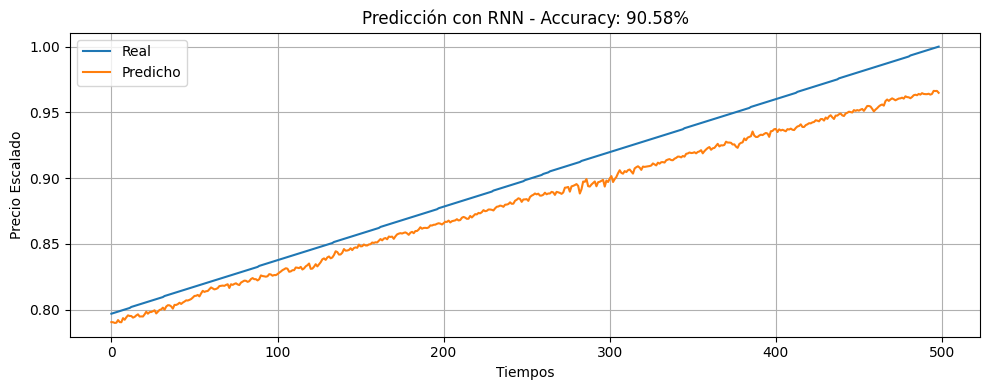

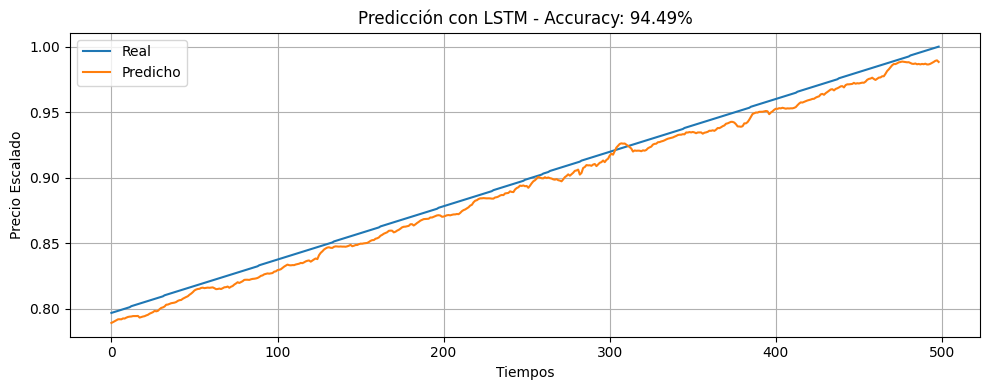

In [60]:
def plot_predictions(Y_true, Y_pred, title, accuracy):
    plt.figure(figsize=(10, 4))
    plt.plot(Y_true[:, 0], label="Real")
    plt.plot(Y_pred[:, 0], label="Predicho")
    
    # Agregar el accuracy al título
    plt.title(f"{title} - Accuracy: {accuracy:.2f}%")
    plt.xlabel("Tiempos")
    plt.ylabel("Precio Escalado")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Calcular accuracy como porcentaje (dentro de ±5% del valor real)
def calculate_accuracy(Y_true, Y_pred, tolerance=0.05):
    accuracy = np.mean(np.isclose(Y_true, Y_pred, atol=tolerance)) * 100
    return accuracy

# Calcular accuracy para RNN y LSTM
rnn_accuracy = calculate_accuracy(Y_test.numpy(), rnn_preds)
lstm_accuracy = calculate_accuracy(Y_test.numpy(), lstm_preds)

# Mostrar los gráficos con el accuracy incluido
plot_predictions(Y_test.numpy(), rnn_preds, "Predicción con RNN", rnn_accuracy)
plot_predictions(Y_test.numpy(), lstm_preds, "Predicción con LSTM", lstm_accuracy)


Este bloque:

Reconstruye las arquitecturas DeepRNN y DeepLSTM.

Carga los pesos guardados desde disco (.pth).

Mueve cada modelo a su respectivo dispositivo (GPU o CPU).

In [59]:
# Cargar un modelo guardado
rnn_model = DeepRNN(n_in, n_hidden, n_out)
rnn_model.load_state_dict(torch.load("rnn_best_model.pth"))
rnn_model.to(device_rnn)

lstm_model = DeepLSTM(n_in, n_hidden, n_out)
lstm_model.load_state_dict(torch.load("lstm_best_model.pth"))
lstm_model.to(device_lstm)

C:\Users\vladi\AppData\Local\Temp\ipykernel_3560\1089556728.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rnn_model.load_state_dict(torch.load("rnn_best_model.pth"))
C

DeepLSTM(
  (lstm): LSTM(6, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)